# Modules

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from community import community_louvain
import matplotlib.cm as cm
import csv
import random

%matplotlib inline

# Functions

In [2]:
def create_kegg_graph(data_df, include_reactions = True):
    
    G = nx.MultiDiGraph()  # At first create multigraph, later it can be converted
    
    unique_entries = []  # List of unique entries. Each gene, ompound, etc needs to be stored as 1 node
    
    # Iterate data to create all nodes
    for index, entry in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and entry['link type']=='reaction':
            continue            
        
        # -- Handle node for Head --
        n1 = entry['head id']
        if n1 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n1)
            
            #Add node n1
            G.add_node(n1)
            # Assign node type
            if n1[0:3] == 'hsa':
                t = 'gene'
            elif n1[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n1.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['head full name'] == '':
                full_name = n1
            else:
                full_name = entry['head full name']
            pathway = str(entry['pathway'])
            attr = {n1: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n1]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n1]['pathways'] = temp

        # -- Handle node for Tail --
        n2 = entry['tail id']
        if n2 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n2)
            
            #Add node n2
            G.add_node(n2)
            # Assign node type
            if n2[0:3] == 'hsa':
                t = 'gene'
            elif n2[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n2.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['tail full name'] == '':
                full_name = n2
            else:
                full_name = entry['tail full name']
            pathway = str(entry['pathway'])
            attr = {n2: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n2]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n2]['pathways'] = temp
        
        
     # Iterate data to find all relations           
    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and row['link type']=='reaction':
            continue 
        
        head = str(row['head id'])
        tail = str(row['tail id'])
        pathway = str(row['pathway'])
        link_type = str(row['link type'])
        rel_name = str(row['relation name'])
        if head in G.nodes and tail in G.nodes:
            G.add_edge(head, tail,pathway = pathway, link_type= link_type, relation_name= rel_name)
        else:
            print('node not found @row '+str(index))
        
    return G

def merge_same_named(G):
    keep = []
    merge = []
    merged_list = []
    for node1 in tqdm(G.nodes):
        for node2 in G.nodes:
            if node1 != node2:
                if G.nodes[node1]['full name'] == G.nodes[node2]['full name']:
                    merged_list.append("Merge: "+node1+" + "+node2+ " as "+G.nodes[node1]['full name'])
                    # Prefer to merge glycan as compound
                    if node1[0:3] == 'cpd':
                        keep.append(node1)
                        merge.append(node2)
                    else:
                        keep.append(node2)
                        merge.append(node1)
                        
    for n1,n2 in zip(keep,merge):
        if n1 in G.nodes and n2 in G.nodes:
            G = nx.contracted_nodes(G,n1,n2)
            
    
    return G, merged_list    

# Load Data

In [3]:
# === load data ===
df_relations = pd.read_csv('../KEGG Pathways Dataset Collection/All_relations-Curated-full_names.csv')
G_directed = create_kegg_graph(df_relations)
G_undirected = nx.Graph(G_directed)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████| 17448/17448 [00:01<00:00, 13330.04it/s]


Graph with 5187 nodes and 11804 edges


In [4]:
# Merge some double occurrences of compounds as glycans
G_undirected,ml = merge_same_named(G_undirected)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████████| 5187/5187 [00:43<00:00, 119.74it/s]


Graph with 5165 nodes and 11791 edges


In [5]:
# Keep main component only. Prevent biased zeros to unconnected nodes
largest_cc = max(nx.connected_components(G_undirected), key=len)
lsmain = list(largest_cc)

G_undirected_main = G_undirected.copy()
remove = []
for node in G_undirected_main.nodes:
    if node not in lsmain:
        remove.append(node)
        
for node in remove:        
    G_undirected_main.remove_node(node)
        
print(G_undirected_main)

Graph with 4810 nodes and 11577 edges


# Find Louvain partitions

Partitions :32


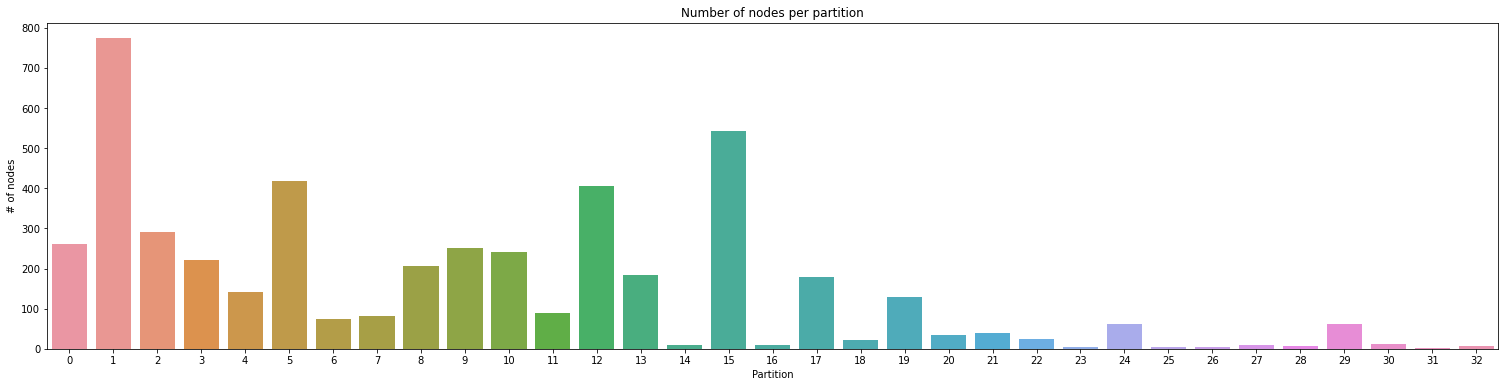

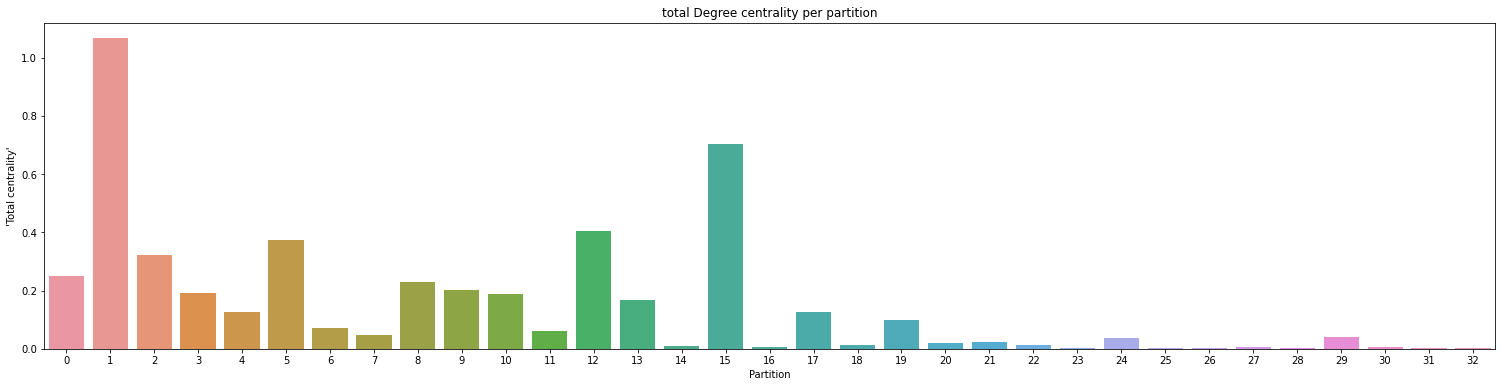

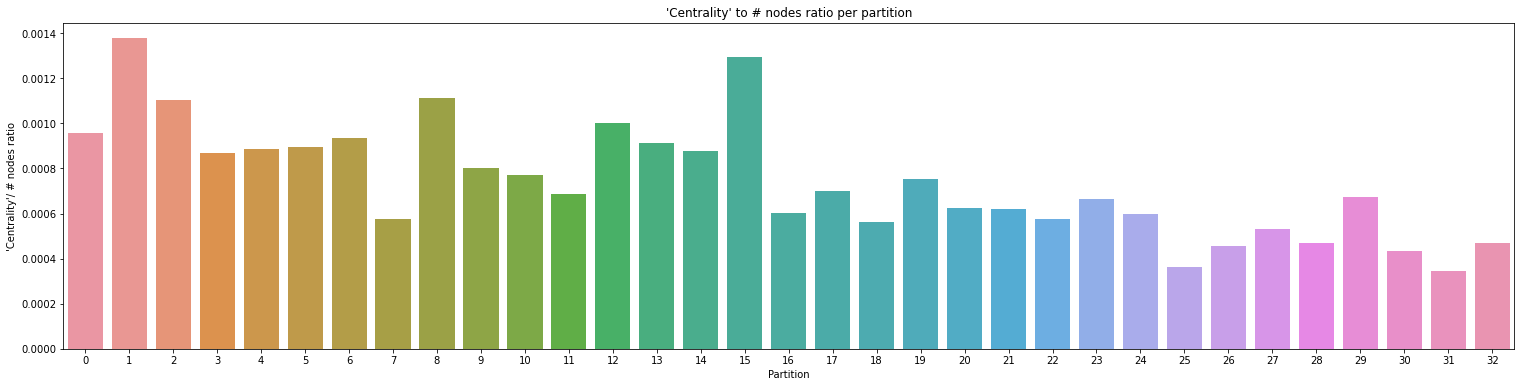

In [6]:
# Find Louvain partitions
partition = community_louvain.best_partition(G_undirected_main,resolution=1.01, random_state = 2023)
num_partitions = max(partition.values())
print("Partitions :" + str(num_partitions))

centrality = nx.degree_centrality(G_undirected_main)
centrality_dict = {}
num_nodes_dict = {}
for i in range(0,num_partitions+1):
    centrality_dict[i] = 0
    num_nodes_dict[i] = 0
        
for node in partition.keys():
    centrality_dict[partition[node]] += centrality[node]
    num_nodes_dict[partition[node]] += 1

plt.figure(figsize=(26,6))  
ax = sns.barplot(x=list(num_nodes_dict.keys()), y = list(num_nodes_dict.values()))
ax.set(xlabel="Partition", ylabel = "# of nodes", title = "Number of nodes per partition")
plt.show()
    
plt.figure(figsize=(26,6))  
ax = sns.barplot(x=list(centrality_dict.keys()), y = list(centrality_dict.values()))
ax.set(xlabel="Partition", ylabel = "'Total centrality'", title = "total Degree centrality per partition")
plt.show()

plt.figure(figsize=(26,6))  
ax = sns.barplot(x=list(centrality_dict.keys()), y = [i / j for i, j in zip(list(centrality_dict.values()), list(num_nodes_dict.values()))])
ax.set(xlabel="Partition", ylabel = "'Centrality'/ # nodes ratio", title = "'Centrality' to # nodes ratio per partition")
plt.show()

# Split Graph

In [7]:
# Try to split main graph into 2 connected Graphs:
# 1. Randomly assign each partition in Graph A or Graph B
# 2. If both Graphs are connected, print their node types and selection of partitions
# 3. Automatically (or manually) decide the best split (most balanced split) based on gene to compound ratios

valid_selections = []
status = tqdm(range(0,30000))
status.set_description("No split found yet. ")
best_diff = 10.1
for tries in status:
    G_A = G_undirected_main.copy()
    selection = []
    
    # Randomly assign partitions to Graph B
    for i in range(0,40):
        if bool(random.randint(0, 1)):  
            selection.append(i)
    
    # Remove the nodes in those partitions to form Graph A    
    for i in selection:
        for node in partition:
            if partition[node] == i:   
                G_A.remove_node(node)
                
    
    if nx.is_connected(G_A):
        
        # Form Graph B
        G_B = G_undirected_main.copy()
        for node in G_A.nodes:
             G_B.remove_node(node)
                
        if nx.is_connected(G_B):
            # Calculate gene to compound ratios and their squared difference, which needs to be minimised
            typesA = list(nx.get_node_attributes(G_A, 'type').values())
            typesB = list(nx.get_node_attributes(G_B, 'type').values())
            ratioA = typesA.count('gene')/typesA.count('compound')
            ratioB = typesB.count('gene')/typesB.count('compound')
            diff = (ratioA - ratioB)**2

            if (selection, diff) not in valid_selections:
                valid_selections.append([selection, diff])
                if diff < best_diff:
                    best_diff = diff
                    status.set_description("Found split(s), best diff="+str(diff)+" ")
    

Found split(s), best diff=0.03753381446082642 : 100%|████████████████████████████| 30000/30000 [48:51<00:00, 10.23it/s]


Found 37 valid selections
Top 3:

Selection #1 (diff= 0.03753381446082642): 
[1, 2, 3, 4, 5, 8, 10, 12, 14, 16, 18, 23, 25, 26, 27, 28, 30, 31, 32, 34, 37, 39]


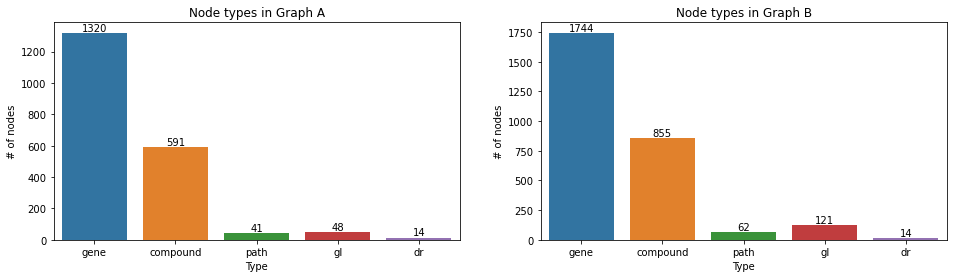

Selection #2 (diff= 0.07400228695319476): 
[0, 1, 2, 3, 4, 6, 7, 9, 11, 14, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30, 31, 32, 37, 38, 39]


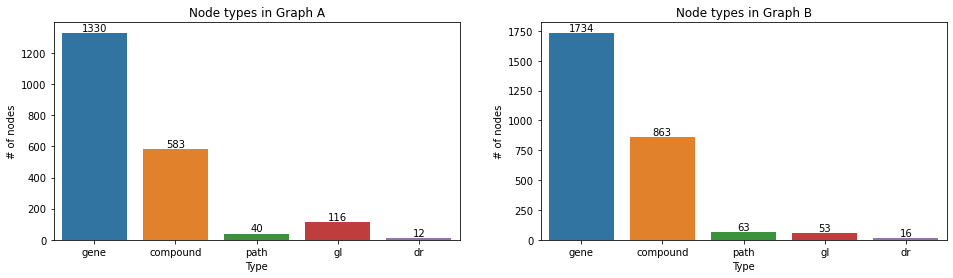

Selection #3 (diff= 0.07503282422057861): 
[0, 1, 2, 3, 6, 8, 9, 10, 14, 17, 18, 19, 20, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 39]


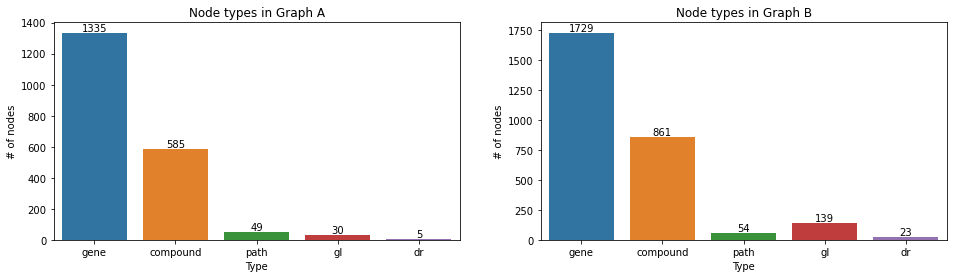

In [8]:
sort_valid_selections = sorted(valid_selections, key=lambda sel: sel[1])
print("Found "+str(len(sort_valid_selections))+" valid selections\nTop 3:\n")
plot_num = min(len(sort_valid_selections),3)

for i in range(plot_num):
    selection = sort_valid_selections[i][0]
    print("Selection #"+str(i+1)+" (diff= "+str(sort_valid_selections[i][1])+"): ")
    print(selection)
    
    G_A = G_undirected_main.copy()
    # Remove the nodes in those partitions to form Graph A
    for i in selection:
        for node in partition:
            if partition[node] == i:   
                G_A.remove_node(node)
    
    # Form Graph B
    G_B = G_undirected_main.copy()
    for node in G_A.nodes:
         G_B.remove_node(node)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    
    # === node types Graph A ===
    types = list(nx.get_node_attributes(G_A, 'type').values())
    sns.countplot(ax = ax[0], x=types, order = ["gene", "compound", "path","gl", "dr"])
    for container in ax[0].containers:
        ax[0].bar_label(container)
    ax[0].set(xlabel="Type", ylabel = "# of nodes", title = "Node types in Graph A")

    # === node types Graph B ===
    types = list(nx.get_node_attributes(G_B, 'type').values())
    sns.countplot(ax = ax[1],x=types, order = ["gene", "compound", "path","gl", "dr"])
    for container in ax[1].containers:
        ax[1].bar_label(container)
    ax[1].set(xlabel="Type", ylabel = "# of nodes", title = "Node types in Graph B")
    plt.show()

Graph A:
Graph with 2014 nodes and 3878 edges
Connected: True
Graph B:
Graph with 2796 nodes and 6507 edges
Connected: True
------------
Common nodes in both Graphs:

------------


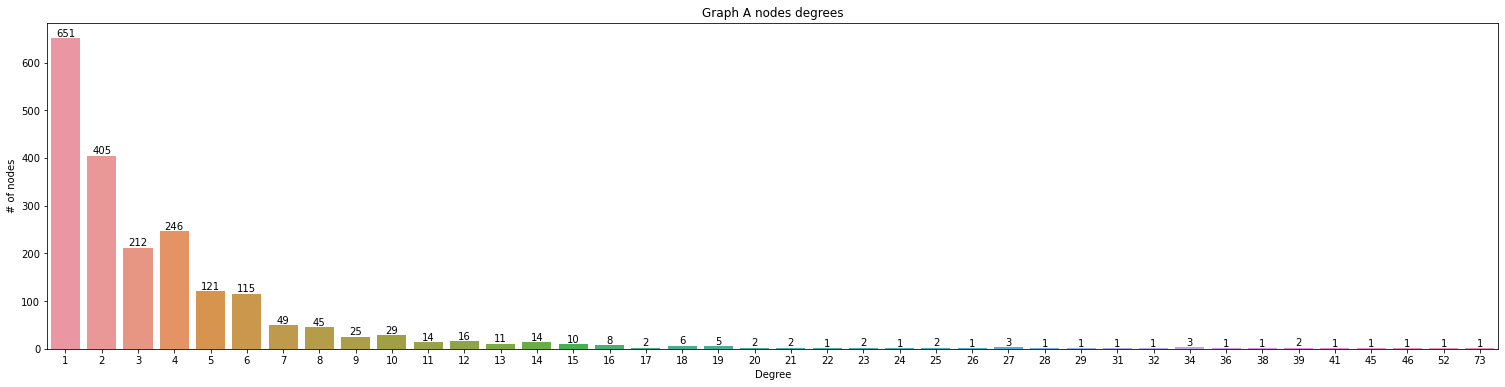

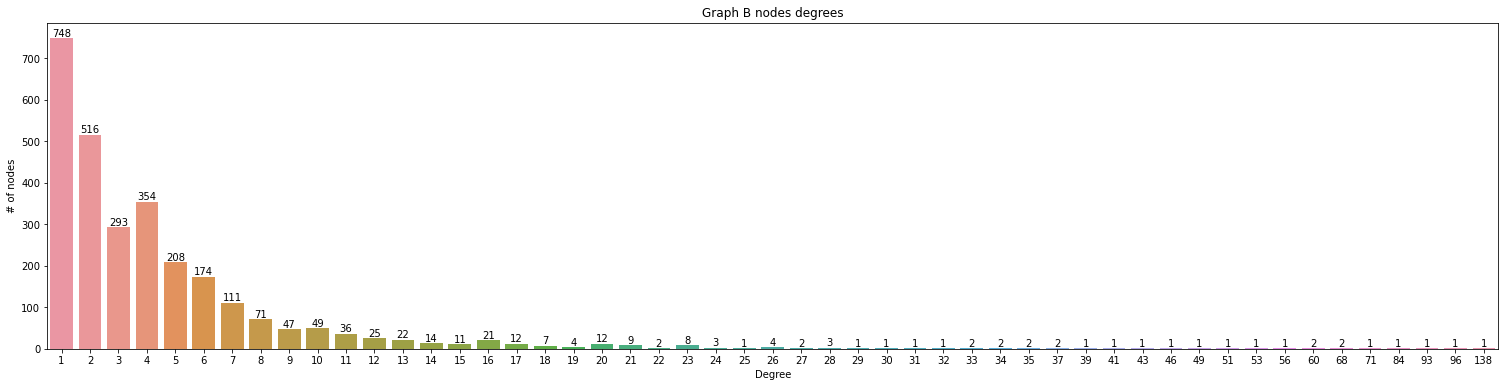

In [9]:
# Manually select a list of partitions to split the dataset
# final_selection = [0, 1, 3, 5, 6, 9, 10, 11, 12, 13, 15, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 38, 39]
# Or pick the best from previously
final_selection = sort_valid_selections[0][0]

G_A = G_undirected_main.copy()

for i in final_selection:
    for node in partition:
        if partition[node] == i:
            G_A.remove_node(node)

print("Graph A:")
print(G_A)
print("Connected: "+str(nx.is_connected(G_A)))            
            
G_B = G_undirected_main.copy()
nodes = list(G_A.nodes)

for node in nodes:
     G_B.remove_node(node)
        
print("Graph B:")
print(G_B)
print("Connected: "+str(nx.is_connected(G_B)))   

# Check if any nodes (node id) contained in both Graphs
print("------------\nCommon nodes in both Graphs:\n")
for node in G_A.nodes:
    if node in G_B.nodes:
        print(node)
print("------------")

# Compare nodes degrees for each Graph
degrees = []

for node in G_A.nodes:
    degrees.append(G_A.degree[node])
        
        
plt.figure(figsize=(26,6))
ax = sns.countplot(x=degrees)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Degree", ylabel = "# of nodes", title = "Graph A nodes degrees")
plt.draw()

degrees = []

for node in G_B.nodes:
    degrees.append(G_B.degree[node])
        
        
plt.figure(figsize=(26,6))
ax = sns.countplot(x=degrees)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Degree", ylabel = "# of nodes", title = "Graph B nodes degrees")
plt.draw()

# Create and save the dataset

In [10]:
# Save exact nodes split for later use if needed
save_version = 'v9'

df_nodes_A = pd.DataFrame(G_A.nodes)
df_nodes_A.to_csv('Hops Dataset '+save_version+' - Nodes A.csv',index=False)

df_nodes_B = pd.DataFrame(G_B.nodes)
df_nodes_B.to_csv('Hops Dataset '+save_version+' - Nodes B.csv',index=False)

In [11]:
# Find shortest path (= Hops) based on original total Graph
visited_nodes = []
Hops_A = []

for node1 in tqdm(G_A.nodes):
    for node2 in G_A.nodes:
        if node2 in visited_nodes:
            continue
        l = nx.shortest_path_length(G_undirected_main, source = node1, target = node2)
        Hops_A.append([G_A.nodes[node1]['full name'], G_A.nodes[node2]['full name'], l])
    
    visited_nodes.append(node1)

print("Total Graph A dataset rows:")    
print(len(Hops_A))

100%|██████████████████████████████████████████████████████████████████████████████| 2014/2014 [03:02<00:00, 11.03it/s]

Total Graph A dataset rows:
2029105


In [12]:
# Find shortest path (= Hops) based on original total Graph
visited_nodes = []
Hops_B = []

for node1 in tqdm(G_B.nodes):
    for node2 in G_B.nodes:
        if node2 in visited_nodes:
            continue
        l = nx.shortest_path_length(G_undirected_main, source = node1, target = node2)
        Hops_B.append([G_B.nodes[node1]['full name'], G_B.nodes[node2]['full name'], l])
    
    visited_nodes.append(node1)

print("Total Graph B dataset rows:")    
print(len(Hops_B))

100%|██████████████████████████████████████████████████████████████████████████████| 2796/2796 [07:37<00:00,  6.11it/s]

Total Graph B dataset rows:
3910206


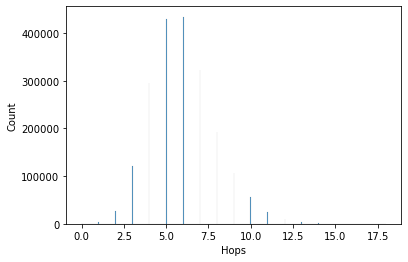

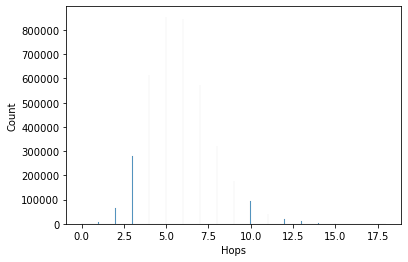

In [13]:
# All data to csv: HEAD - TAIL - HOPS
df_Hops_A = pd.DataFrame(Hops_A,columns = ["Head", "Tail", "Hops"])
df_Hops_A.to_csv('Hops Dataset '+save_version+' - A.csv', index=False)
sns.histplot(df_Hops_A["Hops"])
plt.show()

df_Hops_B = pd.DataFrame(Hops_B,columns = ["Head", "Tail", "Hops"])
df_Hops_B.to_csv('Hops Dataset '+save_version+' - B.csv', index=False)
sns.histplot(df_Hops_B["Hops"])
plt.show()

In [14]:
# SAMPLE Stratified Graph A
df_sub = df_Hops_A.groupby('Hops', group_keys=False).apply(lambda x: x.sample(min(len(x), 100000)))
df_sub.to_csv('Hops Dataset 100K '+save_version+' - A.csv', index=False)

# SAMPLE Stratified Graph B
df_sub = df_Hops_B.groupby('Hops', group_keys=False).apply(lambda x: x.sample(min(len(x), 100000)))
df_sub.to_csv('Hops Dataset 100K '+save_version+' - B.csv', index=False)

In [15]:
# In original Graph, find all distant pairs (>10 Hops)

visited_nodes = []
Hops_Dis = []

for node1 in tqdm(G_undirected_main.nodes):
    for node2 in G_undirected_main.nodes:
        if node2 in visited_nodes:
            continue
        l = nx.shortest_path_length(G_undirected_main, source = node1, target = node2)
        if l > 10:
            Hops_Dis.append([G_undirected_main.nodes[node1]['full name'], G_undirected_main.nodes[node2]['full name'], l])
    
    visited_nodes.append(node1)

print("Total Distant pairs dataset rows:") 
print(len(Hops_Dis))

df_Hops_Dis = pd.DataFrame(Hops_Dis,columns = ["Head", "Tail", "Hops"])
df_Hops_Dis.to_csv('Distant pairs Undirected.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 4810/4810 [24:51<00:00,  3.23it/s]


Total Distant pairs dataset rows:
244686


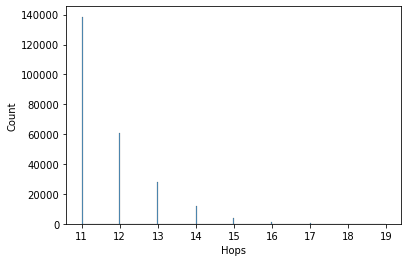

In [16]:
sns.histplot(df_Hops_Dis["Hops"])
plt.show()